<a href="https://www.kaggle.com/code/bteo98/pytorch-human-action-recognition-with-resnet50?scriptVersionId=99294465" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Install Dependencies

In [1]:
!pip install torch_snippets torch_summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 622.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.3 MB/s eta 0:00:00
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26325 sha256=48496ecb29a49f8edd7e747f8dc56363b360d04070016565131389abcfdf73cc
  Stored in directory: /root/.cache/pip/wheels/35/f3/15/01aa6571f0a72ee6ae7b827c1491c37a1f72d686fd22b43b0e
Successfully built typing


# Import Libraries

In [2]:
import torch
from torch import nn, optim
from torchvision import transforms, models
from torch_snippets import *
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary 

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import cv2
from glob import glob
import pandas as pd

sns.set_theme()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [3]:
DIR = "../input/human-action-recognition-har-dataset/Human Action Recognition/"
TRAIN_DIR=f"{DIR}train"
TEST_DIR=f"{DIR}test"
TRAIN_VAL_DF = "../input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv"

In [4]:
train_val_data=glob(TRAIN_DIR+'/*.jpg')
# remove duplicate
train_val_data.remove('../input/human-action-recognition-har-dataset/Human Action Recognition/train/Image_10169(1).jpg')
train_data, val_data = train_test_split(train_val_data, test_size=0.15,
                                       shuffle=True)
print('Train Size', len(train_data))
print('Val Size', len(val_data))

Train Size 10710
Val Size 1890


In [5]:
df=pd.read_csv(f"{DIR}Training_set.csv")
df.head()

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop


In [6]:
agg_labels = df.groupby('label').agg({'label': 'count'})
agg_labels.rename(columns={'label': 'count'})

,count
label,
calling,840
clapping,840
cycling,840
dancing,840
drinking,840
eating,840
fighting,840
hugging,840
laughing,840


In [7]:
ind2cat = sorted(df['label'].unique().tolist())
cat2ind = {cat: ind for ind, cat in enumerate(ind2cat)}

In [8]:
class HumanActionData(Dataset):
    def __init__(self, file_paths, df_path, cat2ind):
        super().__init__()
        self.file_paths = file_paths
        self.cat2ind = cat2ind
        self.df = pd.read_csv(df_path)
        self.transform = transforms.Compose([ 
            transforms.Resize([224, 244]), 
            transforms.ToTensor(),
            # std multiply by 255 to convert img of [0, 255]
            # to img of [0, 1]
            transforms.Normalize((0.485, 0.456, 0.406), 
                                 (0.229*255, 0.224*255, 0.225*255))]
        )
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, ind):
        file_path = self.file_paths[ind]
        itarget = int(fname(file_path)[6:-4])
        target = self.df.iloc[itarget-1]['label']
        target = self.cat2ind[target]
        img = Image.open(file_path).convert('RGB')
        return img, target
    
    def collate_fn(self, data):
        imgs, targets = zip(*data)
        imgs = torch.stack([self.transform(img) for img in imgs], 0)
        imgs = imgs.to(device)
        targets = torch.tensor(targets).long().to(device)
        return imgs, targets
    
    def choose(self):
        return self[np.random.randint(len(self))]

In [9]:
train_ds = HumanActionData(train_data, TRAIN_VAL_DF, cat2ind)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True,
                      collate_fn=train_ds.collate_fn,
                      drop_last=True)

val_ds = HumanActionData(val_data, TRAIN_VAL_DF, cat2ind)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=True,
                    collate_fn=val_ds.collate_fn,
                    drop_last=True)

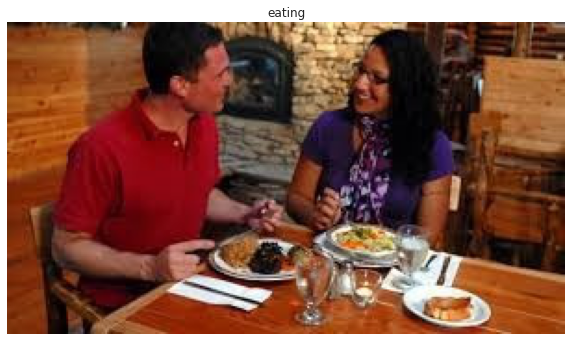

In [10]:
img, target = train_ds.choose()
show(img, title=ind2cat[int(target)])

In [11]:
inspect(*next(iter(train_dl)), names='image, target')

IMAGE:
Tensor	Shape: torch.Size([128, 3, 224, 244])	Min: -0.008	Max: 0.010	Mean: 0.002	dtype: torch.float32 @ cuda:0
TARGET:
Tensor	Shape: torch.Size([128])	Min: 0.000	Max: 14.000	Mean: 7.203	dtype: torch.int64 @ cuda:0


# Model

In [12]:
class ActionClassifier(nn.Module):
    def __init__(self, ntargets):
        super().__init__()
        resnet = models.resnet50(pretrained=True, progress=True)
        modules = list(resnet.children())[:-1] # delete last layer
        self.resnet = nn.Sequential(*modules)
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(resnet.fc.in_features),
            nn.Dropout(0.2),
            nn.Linear(resnet.fc.in_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, ntargets)
        )
    
    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x

In [13]:
classifier = ActionClassifier(len(ind2cat))
_ = summary(classifier, torch.zeros(32,3,224,224).to(device))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2048, 1, 1]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         (75,008)
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         (70,400)
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         (70,400)
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         (379,392)
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         (280,064)
|    |    └─Bottleneck: 3-6              [-1,

## Train

In [14]:
def train(data, classifier, optimizer, loss_fn):
    classifier.train()
    imgs, targets = data
    outputs = classifier(imgs)
    loss = loss_fn(outputs, targets)
    preds = outputs.argmax(-1)
    acc = (sum(preds==targets) / len(targets))
    classifier.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, acc

In [15]:
@torch.no_grad()
def validate(data, classifier, loss_fn):
    classifier.eval()
    imgs, targets = data
    outputs = classifier(imgs)
    loss = loss_fn(outputs, targets)
    preds = outputs.argmax(-1)
    acc = (sum(preds==targets) / len(targets))
    return loss, acc

In [16]:
n_epochs = 50
log = Report(n_epochs)
classifier = ActionClassifier(len(ind2cat)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10,
                                     gamma=0.5)

In [17]:
for epoch in range(n_epochs):
    n_batch = len(train_dl)
    for i, data in enumerate(train_dl):
        train_loss, train_acc = train(data, classifier, 
                                      optimizer, loss_fn)
        pos = epoch + ((i+1)/n_batch)
        log.record(pos=pos, train_loss=train_loss, 
                   train_acc=train_acc, end='\r')
        
    n_batch = len(val_dl)
    for i, data in enumerate(val_dl):
        val_loss, val_acc = validate(data, classifier, loss_fn)
        pos = epoch + ((i+1)/n_batch)
        log.record(pos=pos, val_loss=val_loss, val_acc=val_acc, 
                   end='\r')
    
    scheduler.step()
    log.report_avgs(epoch+1)

EPOCH: 1.000	train_loss: 1.211	train_acc: 0.620	val_loss: 1.431	val_acc: 0.548	(138.47s - 6785.14s remaining)
EPOCH: 2.000	train_loss: 0.867	train_acc: 0.723	val_loss: 0.967	val_acc: 0.687	(214.64s - 5151.40s remaining)
EPOCH: 3.000	train_loss: 0.765	train_acc: 0.757	val_loss: 0.908	val_acc: 0.701	(289.35s - 4533.10s remaining)
EPOCH: 4.000	train_loss: 0.662	train_acc: 0.786	val_loss: 0.931	val_acc: 0.693	(363.87s - 4184.46s remaining)
EPOCH: 5.000	train_loss: 0.578	train_acc: 0.813	val_loss: 0.929	val_acc: 0.711	(438.67s - 3948.02s remaining)
EPOCH: 6.000	train_loss: 0.507	train_acc: 0.837	val_loss: 0.931	val_acc: 0.705	(513.63s - 3766.62s remaining)
EPOCH: 7.000	train_loss: 0.451	train_acc: 0.854	val_loss: 0.940	val_acc: 0.708	(588.62s - 3615.81s remaining)
EPOCH: 8.000	train_loss: 0.399	train_acc: 0.874	val_loss: 0.925	val_acc: 0.713	(663.23s - 3481.96s remaining)
EPOCH: 9.000	train_loss: 0.347	train_acc: 0.889	val_loss: 0.978	val_acc: 0.708	(738.33s - 3363.49s remaining)
EPOCH: 10.

100%|██████████| 151/151 [00:00<00:00, 828.65it/s]


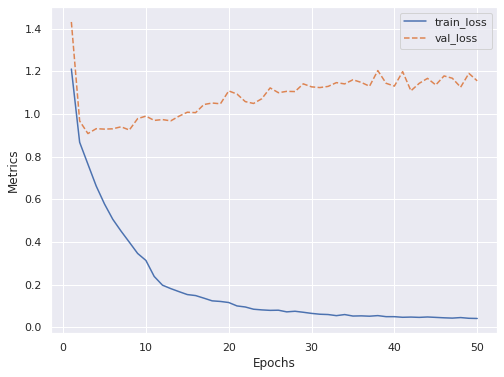

In [18]:
log.plot_epochs(['train_loss', 'val_loss'])

100%|██████████| 151/151 [00:00<00:00, 823.55it/s]


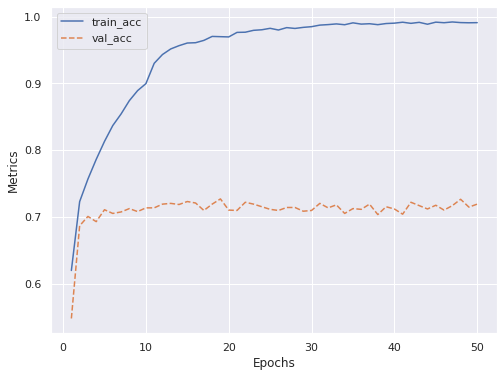

In [19]:
log.plot_epochs(['train_acc', 'val_acc'])

In [20]:
!mkdir saved_model
torch.save(classifier.state_dict(), './saved_model/classifier_weights.pth')